In [1168]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

In [1208]:
data_path  = r'C:\Users\lhauptmann\Code\WristPPG2\data'
save_dir = r'C:\Users\lhauptmann\Code\WristPPG2\data\dataset'
index = 48
participant_name = "martina_4"

imu_file = f"imu_{index:03d}.txt"
ppg_file = f"ppg_{index:03d}.txt"
label_file = f"labels//label_{index:03d}.csv"

LETTER_GESTURES = {
    "a": "Swipe Forward",
    "b": "Swipe Backward",
    "c": "Swipe Left",
    "d": "Swipe Right",
    "p": "Fast Pinch",
    "prr": "Rotate Right",
    "prl": "Rotate Left",
    "pbd": "Back to Default",
    "pc": "Pinch Hold",
    "po": "Pinch Open",
    "sp": "Side Pinch",
    "o": "Nothing",
    "s": "Knock"
}

In [1209]:
def read_txt_data(data_file, n_features = 9, columns = None):

    data = open(data_file, "r").read()

    rows = data.strip().split("\n")

    def pad_to_longest(package_dict, padding_value=0):
        longest = max([len(v) for v in package_dict.values()])
        for k in package_dict.keys():
            package_dict[k] += [padding_value] * (longest - len(package_dict[k]))
        return package_dict

    def update_dict(data_dict, package_dict, package_id=None):
        
        if package_id is not None:
            package_dict["package_id"] = [package_id] * len(package_dict[0])
        
        for k in package_dict.keys():
            data_dict[k].extend(package_dict[k])
        return data_dict


    data_dict = {k:[] for k in range(0,n_features)}
    data_dict["package_id"] = []
    package_dict = {k:[] for k in range(0,n_features)}
    # Loop over each row
    package_id = 0
    previous_key = 100
    start_time = 0
    end_time = 0
    for row in rows:
        if row.startswith('start time'):
            start_time = float(row.split(":")[-1])
            continue
        if row.startswith('end time'):
            end_time = float(row.split(":")[-1])
            continue
        # Split the row by spaces and convert each entry to an integer
        row_split = row.split(" ")
        key = int(row_split[0])  
        data_values = [float(el) for el in row_split[1:] if el != ""]
        if key < previous_key:
            package_dict = pad_to_longest(package_dict, padding_value=np.nan)
            data_dict = update_dict(data_dict, package_dict, package_id)
            package_dict = {k:[] for k in range(0,n_features)}
            package_id += 1
        package_dict[key].extend(data_values)
        previous_key = key
    df_data = pd.DataFrame(data_dict)
    if columns is not None:
        df_data.rename(columns={i:el for i,el in enumerate(columns)}, inplace=True)
    return df_data, start_time, end_time


In [1210]:


imu_columns = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "timestamp", "timestamp_computer"]
ppg_columns = ["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8","ppg_ir_1", "ppg_ir_2","ppg_ir_3", "ppg_ir_4","ppg_ir_5", "ppg_ir_6","ppg_ir_7", "ppg_ir_8", "acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]
df_ppg, ppg_start, ppg_end = read_txt_data(os.path.join(data_path, ppg_file), n_features=19, columns = ppg_columns)
df_imu, imu_start, imu_end = read_txt_data(os.path.join(data_path, imu_file), n_features=8, columns = imu_columns)
df_ppg.dropna(inplace=True)
df_imu.interpolate(inplace=True)
ppg_acc_factor = 4 if index < 8 else 1
df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] = df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] * ppg_acc_factor

labels = pd.read_csv(os.path.join(data_path, label_file))

# setting the imu timestamp to match the ppg timestamp

if (df_imu["timestamp"].diff() < -1000).any(): # most likely overflow in timestamp counter
    jump = df_imu["timestamp"].diff().idxmin()
    df_imu.loc[jump:,"timestamp"] = df_imu.loc[jump:,"timestamp"] + 2**24

df_imu["timestamp"] = (df_imu["timestamp"] - df_imu["timestamp"].iloc[0])/1000 + imu_start

In [1211]:
# setting the ppg timestamp based on the package ids , every package is every 2 seconds
current_package_timestamp = ppg_start
current_timestamp = ppg_start
sampling_rate = 112.22
df_ppg["timestamp"] = 0
current_package_id = df_ppg["package_id"].iloc[0]
for i, row in df_ppg.iterrows():
    if row["package_id"] != current_package_id:
        current_package_id = row["package_id"]
        current_package_timestamp += 2.004#2.004 # should be 2, but empirically found to be 2.004
        current_timestamp = current_package_timestamp
    else:
        current_timestamp += 1/sampling_rate
    df_ppg.at[i, "timestamp"] = current_timestamp
    
while (df_ppg["timestamp"].diff() < 0).any():
    df_ppg = df_ppg[df_ppg["timestamp"].diff() >= 0]


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_25340\225641212.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1729521404.550374' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ppg.at[i, "timestamp"] = current_timestamp


In [1212]:
from scipy.signal import correlate
ppg_imu_cross_correlation = correlate(df_ppg["acc_ppg_x"], df_imu["acc_x"], mode="full")
offset = np.argmax(ppg_imu_cross_correlation) - len(ppg_imu_cross_correlation)//2
df_imu["timestamp"] = df_imu["timestamp"] + offset/sampling_rate

In [1213]:
# looking for calibration peaks to match the data

from scipy.signal import find_peaks

calibration_peaks_ppg = find_peaks(df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean(), height=10, prominence=8, distance=100)
calibration_peaks_imu = find_peaks(df_imu["acc_z"] - df_imu["acc_z"].mean(), height=10, prominence=8, distance=100)
print(calibration_peaks_imu, calibration_peaks_ppg)


(array([596], dtype=int64), {'peak_heights': array([16.8869446]), 'prominences': array([15.64546509]), 'left_bases': array([594], dtype=int64), 'right_bases': array([15686], dtype=int64)}) (array([536], dtype=int64), {'peak_heights': array([25.54484309]), 'prominences': array([30.78051758]), 'left_bases': array([534], dtype=int64), 'right_bases': array([15644], dtype=int64)})


In [1214]:
imu_peak_index = -1
ppg_peak_index = -1

time_offset = df_ppg["timestamp"].iloc[calibration_peaks_ppg[0][ppg_peak_index]] - df_imu["timestamp"].iloc[calibration_peaks_imu[0][imu_peak_index]]
df_ppg["timestamp"] = df_ppg["timestamp"] - time_offset
df_imu.dropna(inplace=True, subset="timestamp")
print(time_offset)

-0.06365633010864258


In [1215]:
df_ppg.set_index("timestamp", inplace=True)
df_imu.set_index("timestamp", inplace=True)

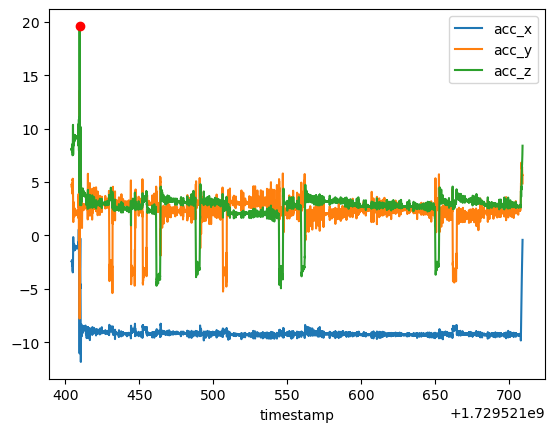

In [1216]:
ax = df_imu.plot( y=["acc_x", "acc_y", "acc_z"])
ax.plot(df_imu.iloc[calibration_peaks_imu[0]]["acc_z"], "ro")

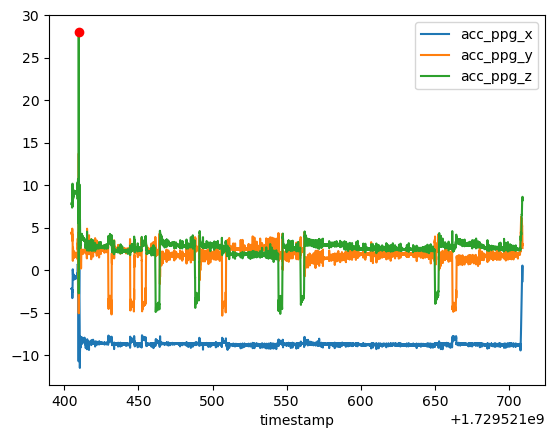

In [1217]:
ax = df_ppg.plot(y=["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"])
ax.plot(df_ppg.iloc[calibration_peaks_ppg[0]]["acc_ppg_z"], "ro")

<Axes: xlabel='timestamp'>

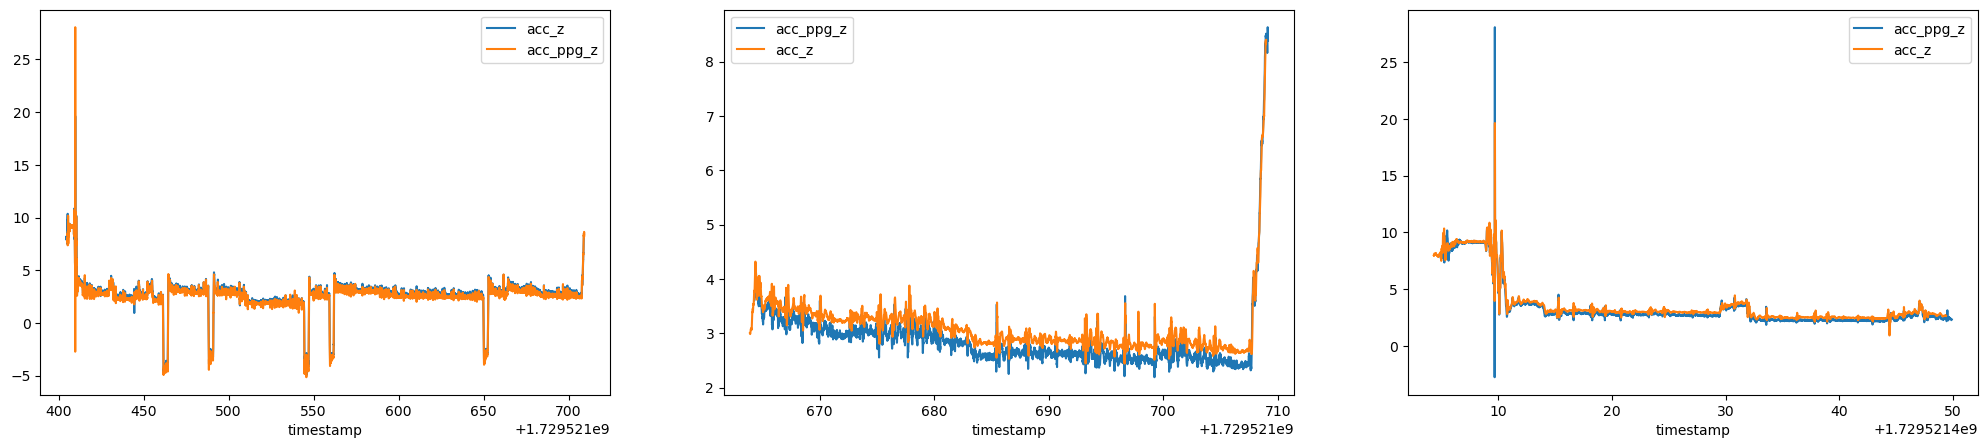

In [1218]:
fig, axes = plt.subplots(1,3, figsize=(25,5))
df_imu.plot( y=["acc_z"], ax=axes[0])
df_ppg.plot( y=["acc_ppg_z"], ax=axes[0])
df_ppg.iloc[:5000].plot(y=["acc_ppg_z"], ax=axes[2])
df_imu.iloc[:5000].plot(y=["acc_z"], ax=axes[2])
df_ppg.iloc[-5000:].plot(y=["acc_ppg_z"], ax=axes[1])
df_imu.iloc[-5000:].plot(y=["acc_z"], ax=axes[1])



In [1219]:
df_imu_re = df_imu.reindex(df_imu.index.union(df_ppg.index))
df_imu_re.interpolate(method='slinear', inplace=True, assume_sorted=False)
df_imu_re = df_imu_re.reindex(df_ppg.index).dropna()
df_ppg_re = df_ppg.reindex(df_imu_re.index)

In [1220]:
calibration_peaks_imu = find_peaks(df_imu_re["acc_z"] - df_imu_re["acc_z"].mean(), height=10, prominence=0, distance=100)[0]
calibration_peaks_ppg = find_peaks(df_ppg_re["acc_ppg_z"] - df_ppg_re["acc_ppg_z"].mean(), height=10, prominence=0, distance=100)[0]
calibration_peaks_ppg, calibration_peaks_imu

(array([536], dtype=int64), array([536], dtype=int64))

[536] timestamp
1.729521e+09    28.050586
Name: acc_ppg_z, dtype: float64


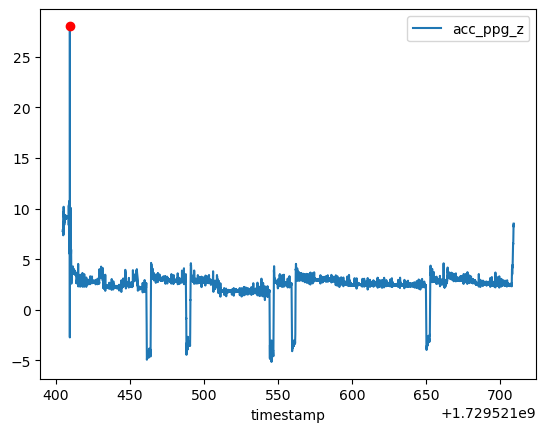

In [1221]:
# plot acc_ppg_z with peaks
df_ppg_re.plot(y=["acc_ppg_z"])
plt.plot(df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"], "ro")
print(calibration_peaks_ppg, df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"])

In [1224]:
start_peak_id = 0
end_peak_id = -1
align_with = ['start']

In [1225]:
ppg_length = df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name
label_length = labels[labels["label"] == "s"]["start_time"].diff().iloc[-1]
ppg_length, label_length

(0.0, 299.6820673942566)

In [1226]:
labels_calibration_start_time = labels[labels["label"] == "s"].iloc[0]["start_time"]
labels_calibration_end_time = labels[labels["label"] == "s"].iloc[-1]["start_time"]
time_diff = []
if 'start' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - labels_calibration_start_time)
if 'end' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name - labels_calibration_end_time)
time_diff = np.mean(time_diff)
labels_re = labels.copy()
labels_re[["start_time", "end_time"]] = labels[["start_time", "end_time"]] + time_diff


if index < 12 and not index == 8:

    for i, row in labels_re.iterrows():
        if row["label"] == "s":
            continue
        previous_end_time = labels_re.iloc[i-1]["end_time"]
        start_time = max(row["start_time"] - 1.4, previous_end_time+0.1)
        labels_re.at[i, "start_time"] = start_time

In [1227]:
df_all = pd.concat([df_imu_re, df_ppg_re], axis=1)

<Axes: xlabel='timestamp'>

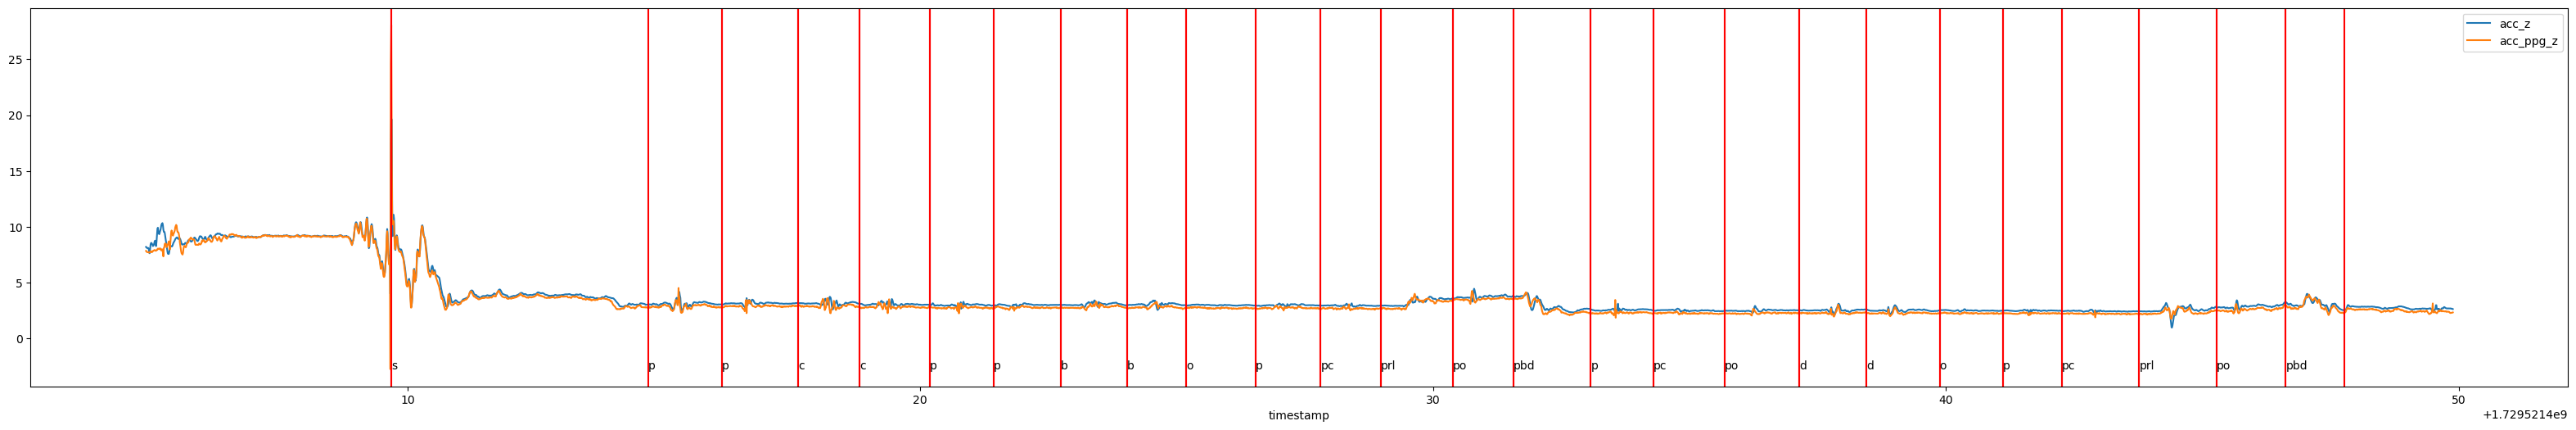

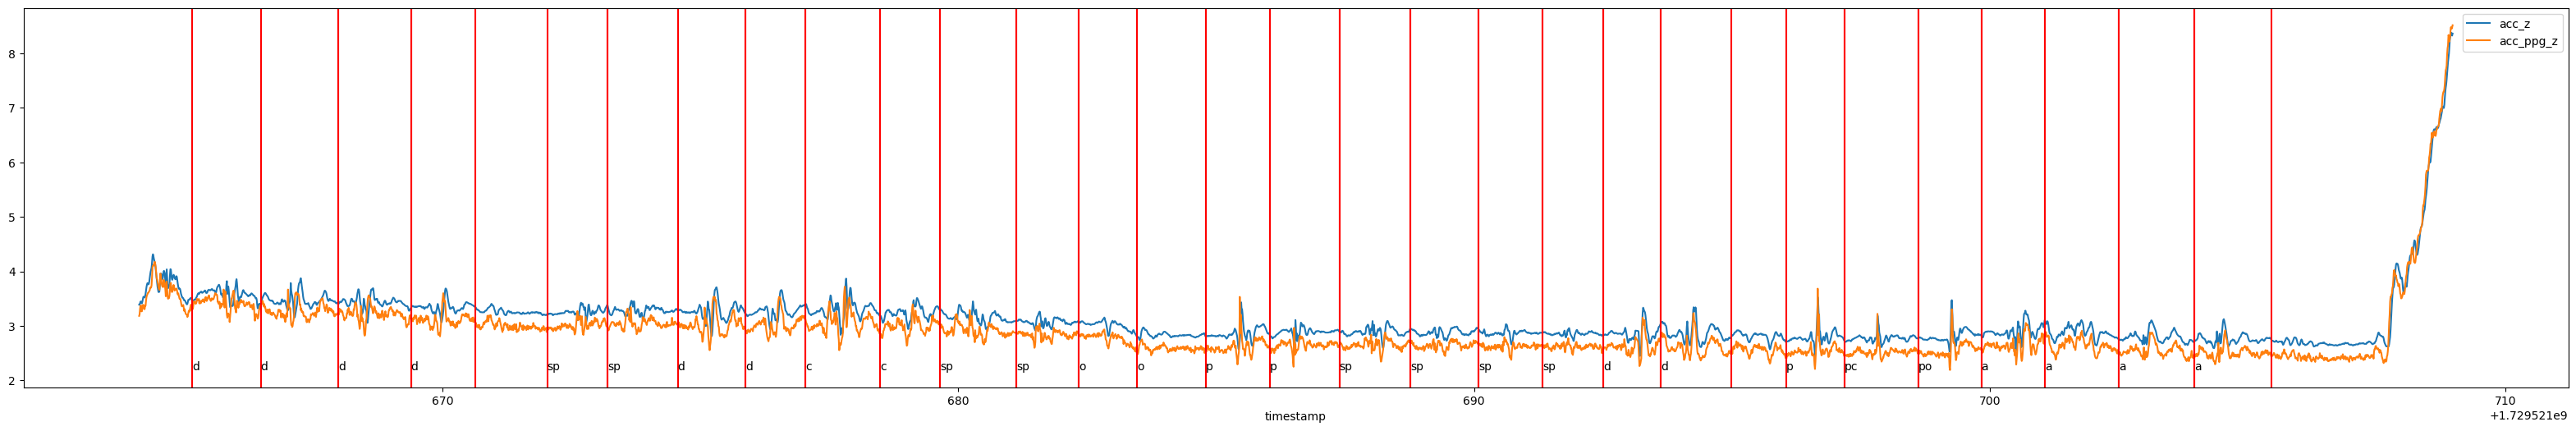

In [1228]:

def plot_with_labels(df ,labels):
    fig, ax = plt.subplots(figsize=(40, 6))
    df.plot(ax=ax)
    df_min = df.min().min() if isinstance(df, pd.DataFrame) else df.min()
    x_range = [df.index[0], df.index[-1]]
    for index, row in labels.iterrows():
        if row["start_time"] < x_range[0] or row["end_time"] > x_range[1]:
            continue
        ax.axvline(x=row["start_time"], color='r')
        ax.axvline(x=row["end_time"], color='r')
        ax.text(row["start_time"] , df_min, row["label"], rotation=0)
    return ax

plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[:5000], labels_re)
plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[-5000:], labels_re)
        

In [1205]:
labels_index = labels_re.copy()

for i, row in labels_re.iterrows():
    label_start = df_all.index[df_all.index > row["start_time"]]
    label_start = label_start[0] if len(label_start) > 0 else df_all.index[-1]
    labels_index.at[i, "start_index"] = df_all.index.get_loc(label_start)
    label_end = df_all.index[df_all.index > row["end_time"]]
    label_end = label_end[0] if len(label_end) > 0 else df_all.index[-1]
    labels_index.at[i, "end_index"] = df_all.index.get_loc(label_end)
labels_index[["start_index", "end_index"]] = labels_index[["start_index", "end_index"]].astype(int)


In [1229]:
df_all.drop(columns=["package_id", "timestamp_computer"], inplace=True)
df_all.reset_index(inplace=True)

assert (labels_index["start_index"] > 0).all()
assert (labels_index["end_index"] < len(df_all)).all()

In [1230]:
import h5py

def save_to_hdf5(df_all, labels_df, output_file):
    # Read the labels from a CSV or pandas dataframe

    # Open an HDF5 file
    with h5py.File(output_file, 'w') as hdf5_file:
        # Iterate over each row of the dataframe
        for idx, row in labels_df.iterrows():
            label = row['label']
            start_index = row['start_index']
            end_index = row['end_index']
            start_time = row['start_time']
            end_time = row['end_time']

            # Create a group named 'Label_Timestamp' (label + index)
            group_name = f"{label}_{int(start_time*1000)}"
            label_group = hdf5_file.create_group(group_name)

            # Save the start and end indexes as datasets in the group
            label_group.create_dataset('start_index', data=start_index)
            label_group.create_dataset('end_index', data=end_index)
            label_group.create_dataset('label', data=label)
            label_group.create_dataset('start_time', data=start_time)
            label_group.create_dataset('end_time', data=end_time)
        
        data_group = hdf5_file.create_group("data")
        for column in df_all.columns:
            data_group.create_dataset(column, data=df_all[column].values)

            

    print(f"Labels saved to {output_file}")
    

save_path = os.path.join(save_dir, "participant_"+ participant_name.split("_")[0], f"participant_{participant_name}.hdf5")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_to_hdf5(df_all, labels_index, save_path)

Labels saved to C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_martina\participant_martina_4.hdf5
